# Heat Transfer project

The aim of the project is to dimensioning an adiabatic exchanger in a typical commercial tertiary building. To do that the building load needs to be first determine.

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Determination of the external parameters

The external temperature and relative humidity will be obtained from meteo datas over a week.

In [393]:
df = pd.read_excel(r"C:\Users\Jolan\Desktop\Heat transfert\Projet\Meteo.xlsx")
#df.head()
#744 lines
#The dates are not well implemented with pandas. In practice there is a measure every hour for 31 days.

In [394]:
#Data storage per day

Datas, data = [], []
#data is a list of couple T,HR along one day
#Datas is the lists of data
for i,T in enumerate(df['T dry bulb (°C)']):
    if i%24 != 0 or i==0: 
        data.append([df['T dry bulb (°C)'][i],df['HR (%)'][i]])
    else:
        Datas.append(data)
        data = []
        data.append([df['T dry bulb (°C)'][i],df['HR (%)'][i]])

The external set temperature will be first taken by doing the **mean of the temperature pic**. 

The external set relative humidity will be taken by doing the **mean of the relative humidity**.

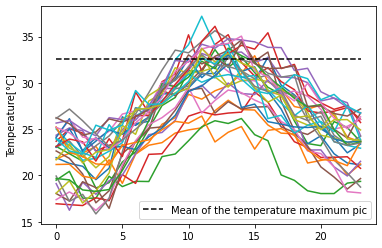

The external temperature selected is 32.54383000972807 °C
The external relative humidity selected is 31.08366961406167 %


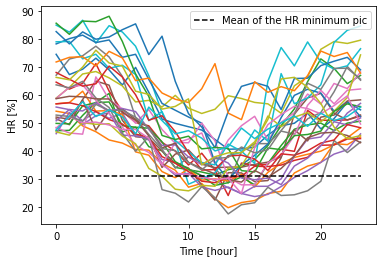

In [395]:
#Plot the different temperatures in a day over a month
#Each plot corresponds to a day

#Creation of the lists
Time,Temp, HR = range(0,24), [],[]
for day in range(30):
    Temp.append([Datas[day][i][0] for i in Time])
    HR.append([Datas[day][i][1] for i in Time])
plt.plot(np.transpose(Temp));
#Mean
MeanT = np.ones(24)*np.mean([np.max(Temp[i]) for i in range(30)])
MeanHR = np.ones(24)*np.mean([np.min(HR[i]) for i in range(30)])

#Plot
plt.plot(Time,MeanT,'--',color = 'black', label = f"Mean of the temperature maximum pic")
plt.ylabel("Temperature[°C]")
plt.legend()
plt.show()
plt.plot(np.transpose(HR));
plt.plot(Time,MeanHR,'--',color = 'black', label = f"Mean of the HR minimum pic")
plt.xlabel("Time [hour]")
plt.ylabel("HR [%]");
plt.legend();
plt.savefig("HR.png",dpi=200)

#Print
T_ext, HR_ext = MeanT[0], MeanHR[0]
print(f'The external temperature selected is {T_ext} °C')
print(f'The external relative humidity selected is {HR_ext} %')

## Calculation of the builing load

$$ Q_{load}= [S_l(\%_{fen}*U_{fen}+(1-\%_{fen})U_{wall})+S(U_{floor}+U_{roof})](T_{ext}-T_{set})+S*(Q_{pers}*N_{pers}+Light)$$

In [396]:
#Parameters
Tset = 25

S = 400
h = 6
Uf = 1.6+0.33+0.6
Ur = 0.25
Sl = 480
Uw = 1.5
Ufen = 1.8
Perfen = 0.4
#Personne and radiation
Np = 1/4 #per/m^2
Qp = 80 #W/per au repos
Light = 5 #W/m^2

In [397]:
def Q_load(Tset, Text):
    return (Text-Tset)*(Sl*(Perfen*Ufen + (1-Perfen)*Uw)+S*(Uf+Ur))+S*(Light+Np*Qp)

In [398]:
Qload = Q_load(Tset,T_ext)

print(f"Q_load is {Qload*1e-3} kW")

Q_load is 24.254821186382156 kW


## Dimensionner

In [399]:
from CoolProp.HumidAirProp import HAPropsSI
import psychrolib as pl

In [400]:
#Parameters
Cp_air = 1005 #J/K/kg
Gp = 0.25 #kg/h/pers

#Hypothesis
m_air = 130* 0.00047194745*Np*S*1.2;print(f'Flux of air is {m_air} kg/s')

#Verifier le temps de renouveler la salle /h
Ren = m_air/1.2*3600/(S*h); print(f'The renewal of the room is done {Ren} per hour') #<30

Flux of air is 7.3623802199999995 kg/s
The renewal of the room is done 9.202975274999998 per hour


In [401]:
def Device(T_ext=T_ext,HR_ext=HR_ext,m_air=m_air,Qload=Qload):
#Deduce T_ air soufflé en K
    T_souf = Tset+273.15 - Qload/(m_air*Cp_air) ; print(f"T_souf = {T_souf-273.15}°C")
    #Calcultation h_ext en J/kg
    h_ext = HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR_ext/100);print(f"h_ext = {h_ext} J/kg")
    #Deduce HR% air soufflé
    HR_souf = HAPropsSI('R', 'T', T_souf, 'P', 101325, 'H', h_ext);print(f"HR_souf = {HR_souf*100}%")
    #Calculation of the efficiency
    Tdb = HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR_ext/100)
    eff = (T_souf-273.15-T_ext)/(Tdb-273.15-T_ext); print(f"The efficiency is {eff*100}%")
    #Calculation of the debit of water
    w_ext = HAPropsSI('W', 'T', T_ext+273.15, 'P', 101325, 'R',HR_ext/100); #kg d'eau/ kg d'air
    w_souff = HAPropsSI('W','T',T_souf,'P',101325,'R',HR_souf); #kg d'eau/ kg d'air
    m_water = m_air*(w_souff-w_ext); print(f"Flux of water is {m_water} kg/s")
    #Deduce HR_set
    w_room = w_souff - (Gp/3600*Np*S)/m_air;
    HR_room = HAPropsSI('R', 'T', Tset+273.15, 'P', 101325, 'W', w_room);print(f"HR_room = {HR_room*100}%")
    #Check if between 40 and 65%
    return m_water,eff,T_souf,HR_souf,HR_room, h_ext

m_water,eff,T_souf,HR_souf,HR_room,h_ext = Device()
#If T_ext_pic and HR_min what is the temperature and HR inside the building:
#For the same device: same efficiency cooler, flow rate of air and flow rate of water.
print("")
print('If the outside temperature is at the highest peak and the relative humidity the lower:')
T_extmax = np.max(Temp) #°C
HR_extmin = np.min(HR) #%
#new T_souff
Tdbmax = HAPropsSI('Twb', 'T', T_extmax+273.15, 'P', 101325, "R", HR_extmin/100)
T_soufmax = T_extmax + eff*(Tdbmax - 273.15-T_extmax);
#new T_set
T_room = T_soufmax+273.15 - Qload/(m_air*Cp_air); print(f'T_roommax = {T_room-273.15} °C')
#new enthalpy
h_extmax = HAPropsSI('H', 'T', T_extmax+273.15,'P', 101325, 'R', HR_extmin/100);
HR_soufmax = HAPropsSI('R', 'T', T_soufmax+273.15, 'P', 101325, 'H', h_extmax);
#new indoor HR
w_souffmax = HAPropsSI('W','T',T_soufmax+273.15,'P',101325,'R',HR_soufmax);
w_roommax = w_souffmax - (Gp/3600*Np*S)/m_air;
HR_roommax = HAPropsSI('R', 'T', T_room, 'P', 101325, 'W', w_roommax);print(f"HR_roommin = {HR_roommax*100}%")

T_souf = 21.72196358880649°C
h_ext = 57195.4744005419 J/kg
HR_souf = 84.90909252282361%
The efficiency is 86.42650365386397%
Flux of water is 0.03214170120054406 kg/s
HR_room = 65.034871469055%

If the outside temperature is at the highest peak and the relative humidity the lower:
T_roommax = 18.611885302977896 °C
HR_roommin = 89.94946821675846%


## Technico-economic

Wp = 93.21093348157778 W
Wf = 5521.785164999999 W
COP = 4.319650585855476
12.751069704071876 semaines


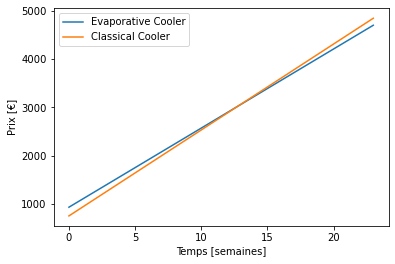

In [402]:
# Work of the pump
deltaP = (30-1)*1e5
Wp = m_water*deltaP/1000; print(f'Wp = {Wp} W')

#Work of the fan
Cons = 0.25*3600 #J/m3
Wf = m_air/1.2*Cons ; print(f'Wf = {Wf} W')

#COP
COP = Qload/(Wp+Wf); print(f'COP = {COP}')

#Price
Prixelec = 0.1740 #€/kWh
Pricepump = 96.78 #€
Pricefan = 834 #€
CAPEX = Pricepump + Pricefan
OPEX = (Wp+Wf)*1e-3*Prixelec*24*7 #€/h

CAPEXClass = 750
OPEXClass = 6.1*Prixelec*24*7

#Plot
Time = range(0,4*6) #jours
Prix = [CAPEX + OPEX*t for t in Time] #€
PrixClass = [CAPEXClass + OPEXClass*t for t in Time] #€
plt.plot(Time,Prix,label = 'Evaporative Cooler')
plt.plot(Time,PrixClass, label = 'Classical Cooler')
plt.xlabel('Temps [semaines]')
plt.ylabel('Prix [€]')
plt.legend()
Tequal = (CAPEX-CAPEXClass)/(OPEXClass-OPEX);print(f'{Tequal} semaines')

## Sensibility study

In [403]:
#Plot function
def Plot(X,Y,color,xlabel = None,ylabel = None,title=None,label=None,linewidth=None):
    plt.plot(X,Y,color = color, label = label,linewidth = linewidth)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if label!=None:
        plt.legend()
        plt.legend(loc=(1.04,0.7))

### Variation of the air flow

One can wonder if the external conditions chosen or if the air flow imposed is optimal for the design of our device.

Here we will look at the different output parameters with different air flow and chosen external conditions to see how sensitive is the model to our chosen parameters.

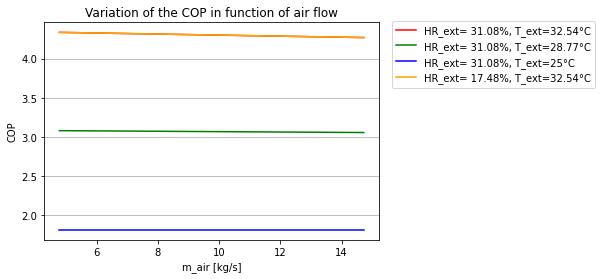

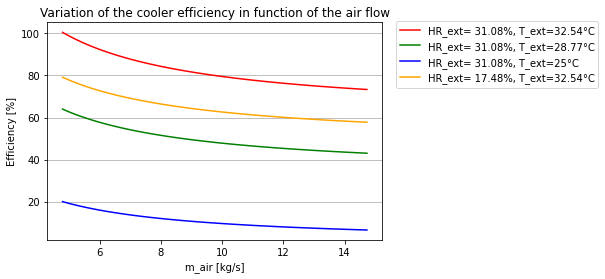

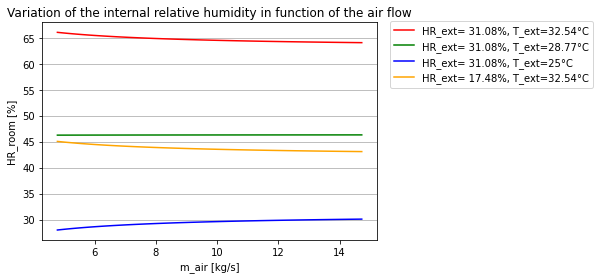

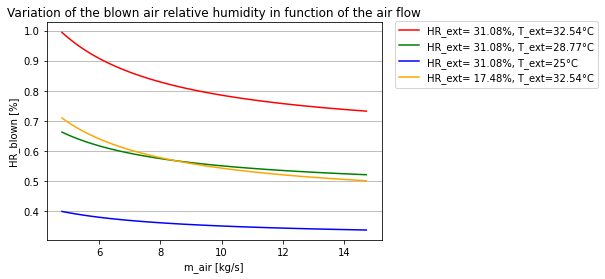

In [404]:
p = 0.65
m_AIR = np.linspace(p*m_air,2*m_air,100) #kg/s

def Variation_mair(T_ext,HR_ext,m_AIR=m_AIR):
    #Deduce T_ air soufflé en K
    Qload = Q_load(Tset,T_ext)
    T_SOUF = [Tset+273.15 - Qload/(m_air*Cp_air) for m_air in m_AIR]
    #Calcultation h_ext en J/kg
    h_ext = HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR_ext/100)
    #Deduce HR% air soufflé
    HR_SOUF = [HAPropsSI('R', 'T', T_souf, 'P', 101325, 'H', h_ext) for T_souf in T_SOUF]
    #Calculation of the efficiency
    Tdb = HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR_ext/100)
    EFF = [((T_souf-273.15-T_ext)/(Tdb-273.15-T_ext))*100 for T_souf in T_SOUF] # %
    #Calculation of the debit of water
    w_ext = HAPropsSI('W', 'T', T_ext+273.15, 'P', 101325, 'R',HR_ext/100); #kg d'eau/ kg d'air
    w_SOUF = [HAPropsSI('W','T',T_souf,'P',101325,'R',HR_souf) for (T_souf,HR_souf) in zip(T_SOUF,HR_SOUF)] #kg d'eau/ kg d'air
    m_WATER = [m_air*(w_souf-w_ext) for (m_air,w_souf) in zip(m_AIR,w_SOUF)] #kg/s
    #Deduce HR_set
    w_ROOM = [w_souf - (Gp/3600*Np*S)/m_air for (m_air,w_souf) in zip(m_AIR,w_SOUF)]
    HR_ROOM = [HAPropsSI('R', 'T', Tset+273.15, 'P', 101325, 'W', w_room)*100 for w_room in w_ROOM]
    #COP
    # Work of the pump
    WP = [m_water*deltaP/1000 for m_water in m_WATER]
    #Work of the fan
    WF = [m_air/1.2*Cons for m_air in m_AIR]
    #COP
    COP = [Qload/(Wp+Wf) for Wp in WP]
    return COP,EFF,HR_ROOM,HR_SOUF

#Datas
COP,EFF,HR_ROOM,HR_SOUF = Variation_mair(T_ext,HR_ext,m_AIR)
COP2,EFF2,HR_ROOM2,HR_SOUF2 = Variation_mair(np.mean([Tset,T_ext]),HR_ext,m_AIR)
COP3,EFF3,HR_ROOM3,HR_SOUF3 = Variation_mair(Tset,HR_ext,m_AIR)
COP4,EFF4,HR_ROOM4,HR_SOUF4 = Variation_mair(T_ext,np.min(HR),m_AIR)
#Legend
Fixed = f'HR_ext= {round(HR_ext,2)}%, T_ext={round(T_ext,2)}°C'
Fixed2 = f'HR_ext= {round(HR_ext,2)}%, T_ext={round(np.mean([Tset,T_ext]),2)}°C'
Fixed3 = f'HR_ext= {round(HR_ext,2)}%, T_ext={round(Tset,2)}°C'
Fixed4 = f'HR_ext= {round(np.min(HR),2)}%, T_ext={round(T_ext,2)}°C'
#Plot
Plot(m_AIR,COP,'red','m_air [kg/s]','COP',
     'Variation of the COP in function of the air flow',Fixed)
Plot(m_AIR,COP2,'green','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow', label = Fixed2)
Plot(m_AIR,COP3,'blue','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow',label = Fixed3)
Plot(m_AIR,COP4,'orange','m_air [kg/s]','COP',
     'Variation of the COP in function of air flow',label = Fixed4)
plt.grid(axis='y')
#plt.savefig("COP.png",dpi=200)
plt.show()

Plot(m_AIR,EFF,'red','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed)
Plot(m_AIR,EFF2,'green','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed2)
Plot(m_AIR,EFF3,'blue','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed3)
Plot(m_AIR,EFF4,'orange','m_air [kg/s]','Efficiency [%]',
     'Variation of the cooler efficiency in function of the air flow',Fixed4)
plt.grid(axis='y')
#plt.savefig("EFF.png",dpi=200)
plt.show()

Plot(m_AIR,HR_ROOM,'red','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed)
Plot(m_AIR,HR_ROOM2,'green','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed2)
Plot(m_AIR,HR_ROOM3,'blue','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed3)
Plot(m_AIR,HR_ROOM4,'orange','m_air [kg/s]','HR_room [%]',
     'Variation of the internal relative humidity in function of the air flow',Fixed4)
plt.grid(axis='y')
#plt.savefig("HR_ROOM.png",dpi=200)
plt.show()

Plot(m_AIR,HR_SOUF,'red','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed)
Plot(m_AIR,HR_SOUF2,'green','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed2)
Plot(m_AIR,HR_SOUF3,'blue','m_air [kg/s]','HR_souf [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed3)
Plot(m_AIR,HR_SOUF4,'orange','m_air [kg/s]','HR_blown [%]',
     'Variation of the blown air relative humidity in function of the air flow',Fixed4)
plt.grid(axis='y')
#plt.savefig("HR_SOUFF.png",dpi=200)

Need to pay attention that looking at the blue curve with an external temperature lower than the internal is not relevant. Indeed, the aim is to cool down the space, so the cooler will be simply off in that case.

### Verify the stability at a constant air flow

This part is less representative that the previous part, but allow to see indepdently of the mass flow rate the evolution of a paramter over an other.
Instinctively we conclued that our solution was already good, but what is the best one possible? We will try it on this part with different devices characteretics.

Added to anlysis over the probability that the external conditions happenned

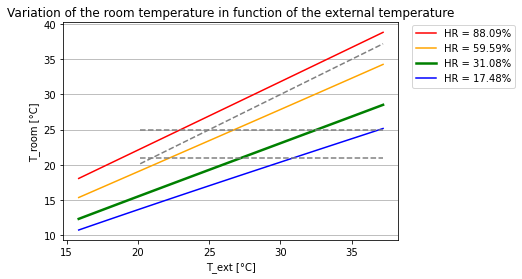

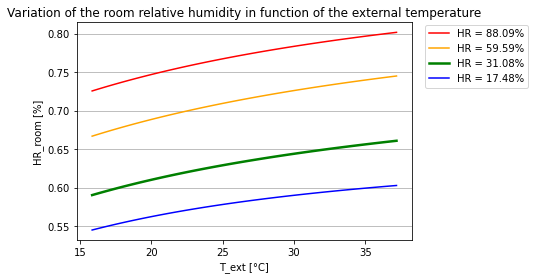

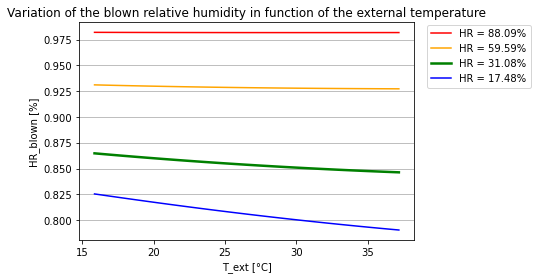

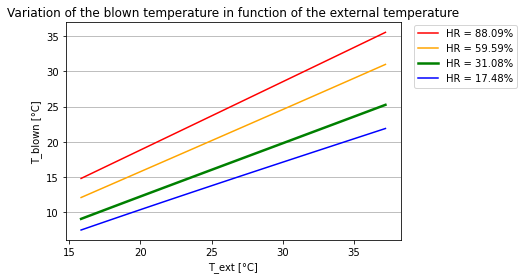

In [423]:
#For the same device: same efficiency cooler, flow rate of air and flow rate of water.
T_EXT = np.linspace(np.min(Temp),np.max(Temp),100) #°C
#HR_EXT = np.linspace(np.min(HR),np.max(HR),100)

def VariationExtTemp(m_air,m_water,eff, Qload,HR=HR_ext,Tset=Tset,T_EXT=T_EXT):
    #Calculation of the heat delivered
    #new T_souff
    TDB = [HAPropsSI('Twb', 'T', T_ext+273.15, 'P', 101325, "R", HR/100) for T_ext in T_EXT]
    T_SOUF = [T_ext + eff*(Tdb - 273.15-T_ext) for (T_ext,Tdb) in zip(T_EXT,TDB)]
    #new T_set
    T_ROOM = [T_souf+273.15 + Qload/(m_air*Cp_air) for T_souf in T_SOUF] #K
    #new enthalpy
    h_EXT = [HAPropsSI('H', 'T', T_ext+273.15,'P', 101325, 'R', HR/100) for T_ext in T_EXT]
    HR_SOUF =[ HAPropsSI('R', 'T', T_souf+273.15, 'P', 101325, 'H', h_ext) for (T_souf,h_ext) in zip(T_SOUF,h_EXT)]
    #new indoor H
    w_SOUF = [HAPropsSI('W','T',T_souf+273.15,'P',101325,'R',HR_souf) for (T_souf,HR_souf) in zip(T_SOUF,HR_SOUF)]
    w_ROOM = [w_souf - (Gp/3600*Np*S)/m_air for w_souf in w_SOUF]
    HR_ROOM = [HAPropsSI('R', 'T', T_room, 'P', 101325, 'W', w_room) for (T_room,w_room) in zip(T_ROOM,w_ROOM)]
    #Convert
    T_ROOM = [T_room-273.15 for T_room in T_ROOM]
    return T_ROOM, HR_ROOM,HR_SOUF,T_SOUF

#Datas
T_ROOM, HR_ROOM, HR_SOUF, T_SOUF = VariationExtTemp(m_air,m_water,eff,Qload,HR=np.max(HR))
T_ROOM2, HR_ROOM2, HR_SOUF2, T_SOUF2 = VariationExtTemp(m_air,m_water,eff,Qload, HR=np.mean([np.max(HR),HR_ext]))
T_ROOM3, HR_ROOM3, HR_SOUF3, T_SOUF3 = VariationExtTemp(m_air,m_water,eff,Qload,HR=HR_ext)
T_ROOM4, HR_ROOM4, HR_SOUF4, T_SOUF4 = VariationExtTemp(m_air,m_water,eff,Qload,HR=np.min(HR))

def Plot2(T_ROOM, HR_ROOM, HR_SOUF, T_SOUF,
          T_ROOM2, HR_ROOM2, HR_SOUF2, T_SOUF2,
          T_ROOM3, HR_ROOM3, HR_SOUF3, T_SOUF3,
          T_ROOM4, HR_ROOM4, HR_SOUF4, T_SOUF4):
    #Legend
    Legend = f'HR = {round(np.max(HR),2)}%'
    Legend2 = f'HR = {round(np.mean([np.max(HR),HR_ext]),2)}%'
    Legend3 = f'HR = {round(HR_ext,2)}%'
    Legend4 = f'HR = {round(np.min(HR),2)}%'
    #Plot
    Plot(T_EXT,T_ROOM,'red','T_ext [°C]','T_room [°C]',
     'Variation of the room temperature in function of the external temperature',Legend)
    Plot(T_EXT,T_ROOM2,'orange','T_ext [°C]','T_room [°C]',
     'Variation of the room temperature in function of the external temperature',Legend2)
    Plot(T_EXT,T_ROOM3,'green','T_ext [°C]','T_room [°C]',
     'Variation of the room temperature in function of the external temperature',Legend3,linewidth = 2.5)
    Plot(T_EXT,T_ROOM4,'blue','T_ext [°C]','T_room [°C]',
     'Variation of the room temperature in function of the external temperature',Legend4)
    #Define the box of the our wanted room temperature
    T_EXTbis = T_EXT[T_EXT >20]
    plt.plot(T_EXTbis,T_EXTbis,'--',color='grey')
    gap = 4
    TSET = [Tset for Text in T_EXTbis]
    TSET2 = [Tset-gap for Text in T_EXTbis]
    plt.plot(T_EXTbis,TSET,'--',color='grey')
    plt.plot(T_EXTbis,TSET2,'--',color='grey')
    plt.grid(axis='y')
    plt.show()

    Plot(T_EXT,HR_ROOM,'red','T_ext [°C]','HR_room [%]',
     'Variation of the room relative humidity in function of the external temperature',Legend)
    Plot(T_EXT,HR_ROOM2,'orange','T_ext [°C]','HR_room [%]',
     'Variation of the room relative humidity in function of the external temperature',Legend2)
    Plot(T_EXT,HR_ROOM3,'green','T_ext [°C]','HR_room [%]',
     'Variation of the room relative humidity in function of the external temperature',Legend3,linewidth = 2.5)
    Plot(T_EXT,HR_ROOM4,'blue','T_ext [°C]','HR_room [%]',
     'Variation of the room relative humidity in function of the external temperature',Legend4)
    plt.grid(axis='y')
    plt.show()

    Plot(T_EXT,HR_SOUF,'red','T_ext [°C]','HR_blown [%]',
     'Variation of the blown relative humidity in function of the external temperature',Legend)
    Plot(T_EXT,HR_SOUF2,'orange','T_ext [°C]','HR_blown [%]',
     'Variation of the blown relative humidity in function of the external temperature',Legend2)
    Plot(T_EXT,HR_SOUF3,'green','T_ext [°C]','HR_blown [%]',
     'Variation of the blown relative humidity in function of the external temperature',Legend3,linewidth = 2.5)
    Plot(T_EXT,HR_SOUF4,'blue','T_ext [°C]','HR_blown [%]',
     'Variation of the blown relative humidity in function of the external temperature',Legend4)
    plt.grid(axis='y')
    plt.show()

    Plot(T_EXT,T_SOUF,'red','T_ext [°C]','T_blown [°C]',
     'Variation of the blown temperature in function of the external temperature',Legend)
    Plot(T_EXT,T_SOUF2,'orange','T_ext [°C]','T_blown [°C]',
     'Variation of the blown temperature in function of the external temperature',Legend2)
    Plot(T_EXT,T_SOUF3,'green','T_ext [°C]','T_blown [°C]',
     'Variation of the blown temperature in function of the external temperature',Legend3,linewidth = 2.5)
    Plot(T_EXT,T_SOUF4,'blue','T_ext [°C]','T_blown [°C]',
     'Variation of the blown temperature in function of the external temperature',Legend4)
    plt.grid(axis='y')
    plt.show()

Plot2(T_ROOM, HR_ROOM, HR_SOUF, T_SOUF,
          T_ROOM2, HR_ROOM2, HR_SOUF2, T_SOUF2,
          T_ROOM3, HR_ROOM3, HR_SOUF3, T_SOUF3,
          T_ROOM4, HR_ROOM4, HR_SOUF4, T_SOUF4)

Reaching a certain relative humidity, it seems that the device is not efficient at all giving temperature higher than the external temperature

For some part of the curve we can also wonder if those are possible points. For instance 88% humidity at 37°C is not.

In [424]:
def RealCondT(T_ROOM, HR):
    #Return the percentage of meteo data conditions when the room temperature is over the max Tset of 25°C
    res = 0
    T_ROOM = np.array(T_ROOM)
    #give the corresponding external temperature (first Text when Troom is higher than 25)
    T = T_EXT[np.where(T_ROOM >= 25)[0][0]]
    #All the humidity over this temperature:
    Moisture = df['HR (%)'][df['T dry bulb (°C)']>T]
    #Search if there is one greater than the corresponding humidity 
    for m in Moisture:
        if m>HR:
            res+=1
    return f'{round(res/len(Moisture)*100,2)}%'


def RealCondHR(HR_ROOM, HR):
    #Return the percentage of meteo data conditions when the room temperature is over the max Tset of 25°C
    res = 0
    HR_ROOM = np.array(HR_ROOM)
    #give the limit external temperature
    T = T_EXT[np.where(HR_ROOM >= 0.7)[0][0]]
    #All the humidity over this temperature:
    Moisture = df['HR (%)'][df['T dry bulb (°C)']>T]
    #Search if there is one greater than the corresponding humidity 
    for m in Moisture:
        if m>HR:
            res+=1
    return f'{round(res/len(Moisture)*100,2)}%'

# For the point of our first device:
#For the room temperature plot
print(RealCondT(T_ROOM,np.max(HR)))
print(RealCondT(T_ROOM2,np.mean([np.max(HR),HR_ext])))
print(RealCondT(T_ROOM3,HR_ext))
print("")
#For the relative humidity plot
print(RealCondHR(HR_ROOM,np.max(HR)))
print(RealCondHR(HR_ROOM2,np.mean([np.max(HR),HR_ext])))

0.0%
4.79%
63.93%

0.0%
21.85%


In practice with this test, we confirm that the device do not gives a higher temperature than the external one. And that the red curves correspond to zero possible scenario, but still can be used at a visual upper limit.

We can change the design by saying that: 
- if the device gives a temperature too small to be comfortable, then we can put it off.
- The relative humidity needs to be between 40 and 70%: choice of the device function: a lot HR_ext,T_ext, not much m_air
- The efficnecy needs to be relevant ( less than 85%)
- The flow rate does not play an important part on the parameters of interest when high (even for the COP) so it can be used to adjust the realisation of the model ( as long as the renewal of the room is under 30 room/h)
- The air blown needs to be lower than 85%

T_souf = 22.807355804739302°C
h_ext = 57195.4744005419 J/kg
HR_souf = 77.01306611177272%
The efficiency is 77.75825266392019%
Flux of water is 0.058869433268996935 kg/s
HR_room = 65.22752225525028%


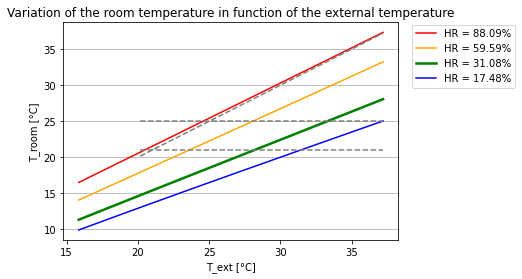

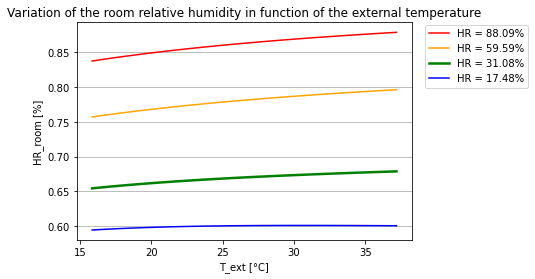

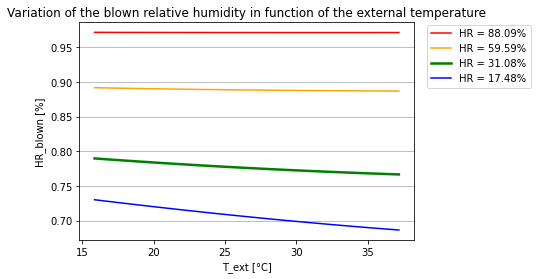

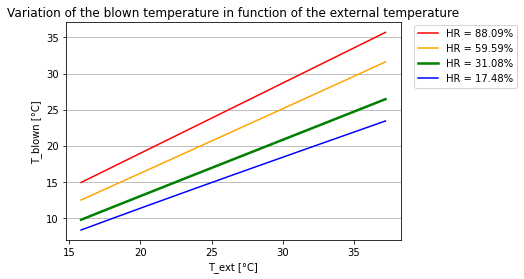

0.0%
2.28%
63.41%

0.0%
23.96%


In [422]:
#Other design device:
m_air2 = 15 #kg/s
T_ext2 = T_ext
HR_ext2 = HR_ext
Qload2 = Q_load(Tset, np.max(Temp))
m_water2, eff2,_ ,_ ,_ ,_ = Device(T_ext2, HR_ext2, m_air2, Qload2)

#Datas
T_ROOMD2, HR_ROOMD2, HR_SOUFD2, T_SOUFD2 = VariationExtTemp(m_air2,m_water2,eff2,Qload,HR=np.max(HR))
T_ROOM2D2, HR_ROOM2D2, HR_SOUF2D2, T_SOUF2D2 = VariationExtTemp(m_air2,m_water2,eff2,Qload, HR=np.mean([np.max(HR),HR_ext]))
T_ROOM3D2, HR_ROOM3D2, HR_SOUF3D2, T_SOUF3D2 = VariationExtTemp(m_air2,m_water2,eff2,Qload,HR=HR_ext)
T_ROOM4D2, HR_ROOM4D2, HR_SOUF4D2, T_SOUF4D2 = VariationExtTemp(m_air2,m_water2,eff2,Qload,HR=np.min(HR))

Plot2(T_ROOMD2, HR_ROOMD2, HR_SOUFD2, T_SOUFD2,
T_ROOM2D2, HR_ROOM2D2, HR_SOUF2D2, T_SOUF2D2,
T_ROOM3D2, HR_ROOM3D2, HR_SOUF3D2, T_SOUF3D2,
T_ROOM4D2, HR_ROOM4D2, HR_SOUF4D2, T_SOUF4D2)

#Check the pertinence of this device
#In the room temperature plot
print(RealCondT(T_ROOMD2,np.max(HR)))
print(RealCondT(T_ROOM2D2,np.mean([np.max(HR),HR_ext])))
print(RealCondT(T_ROOM3D2,HR_ext))
print("")

#For the relative humidity plot
print(RealCondHR(HR_ROOMD2,np.max(HR)))
print(RealCondHR(HR_ROOM2D2,np.mean([np.max(HR),HR_ext])))
#print(RealCondHR(HR_ROOM3D2,HR_ext))

By adjusting the air flow rate, the blown air humidity is now more acceptable and the room temperature and moisture did not change much.